In [143]:
from collections.abc import Sequence
import itertools
from time import perf_counter
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from scipy.spatial.distance import euclidean
from scipy.spatial.transform import Rotation
import vedo

from histalign.backend.ccf.paths import get_atlas_path
from histalign.backend.io import load_volume
from histalign.backend.maths import compute_centre, compute_normal_from_raw
from histalign.backend.models import (
    Orientation,
    Resolution,
)
from histalign.backend.models.errors import InvalidOrientationError

vedo.settings.default_backend = "vtk"

In [144]:
def imshow(image: np.ndarray) -> None:
    _ = plt.figure()

    plt.imshow(image)
    plt.axis(False)

    plt.show()


def show(meshes: vedo.CommonVisual | list[vedo.CommonVisual]) -> None:
    plotter = vedo.Plotter(axes=4)

    if not isinstance(meshes, list):
        meshes = [meshes]

    for mesh in meshes:
        plotter += mesh

    plotter.show(interactive=False).interactive().close()


def compute_origin_from_raw(
    centre: Sequence[int], offset: int, orientation: Orientation
) -> np.ndarray:
    if len(centre) != 3:
        raise ValueError(f"Centre should be 3 coordinates. Got {len(centre)}.")

    match orientation:
        case Orientation.CORONAL:
            origin = [centre[0] + offset, centre[1], centre[2]]
        case Orientation.HORIZONTAL:
            origin = [centre[0], centre[1] + offset, centre[2]]
        case Orientation.SAGITTAL:
            origin = [centre[0], centre[1], centre[2] + offset]
        case other:
            raise InvalidOrientationError(other)

    return np.array(origin)


def extract_significant_corners(points: np.ndarray) -> np.ndarray:
    min1 = points.argmin(axis=0)[0]
    min2 = points.argmin(axis=0)[-1]

    max1 = points.argmax(axis=0)[0]
    max2 = points.argmax(axis=0)[-1]

    print(min1, min2, max1, max2)

    if min1 != min2:
        if points[min1, 0] == points[min2, 0] or points[min1, -1] == points[min2, -1]:
            min1 = max(min1, min2)
        else:
            raise ValueError("Minimum X and minimum Z do not belong to the same point.")
    elif max1 != max2:
        if points[max1, 0] == points[max2, 0] or points[max1, -1] == points[max2, -1]:
            max1 = max(max1, max2)
        else:
            raise ValueError("Maximum X and maximum Z do not belong to the same point.")

    return points[[min1, max1]]


def magnitude(v):
    return np.sqrt(np.sum(np.array(v) ** 2))


def vector_angle(v1, v2):
    return math.degrees(math.acos(np.dot(v1, v2) / (magnitude(v1) * magnitude(v2))))


def cut_with_planes(plane, origins, normals):
    shape = plane.metadata["shape"]

    plane.cut_with_planes(origins=origins[::2], normals=normals[::2], invert=True)

    shape[1] = len(plane.points) / shape[0]

    plane.cut_with_planes(origins=origins[1::2], normals=normals[1::2], invert=True)

    shape[0] = len(plane.points) / shape[1]
    plane.metadata["shape"] = shape


def extract_significant_points(source: vedo.CommonAlgorithms) -> np.ndarray:
    points = source.points
    bounds = source.bounds()

    minimum_xs = points[points[:, 0] == bounds[0]]
    maximum_xs = points[points[:, 0] == bounds[1]]
    minimum_ys = points[points[:, 1] == bounds[2]]
    maximum_ys = points[points[:, 1] == bounds[3]]
    minimum_zs = points[points[:, 2] == bounds[4]]
    maximum_zs = points[points[:, 2] == bounds[5]]

    # Look for smallest X and either smallest or largest Z
    point1 = None
    for point in minimum_xs:
        if (
            point in minimum_zs
            or point in maximum_zs
            or point in minimum_ys
            or point in maximum_ys
        ):
            point1 = point
            break

    # Look for largest X and either smallest or largest Z
    point2 = None
    for point in maximum_xs[::-1]:
        if (
            point in minimum_zs
            or point in maximum_zs
            or point in minimum_ys
            or point in maximum_ys
        ):
            point2 = point
            break

    return np.vstack((point1, point2))


def simulate(offset: int, pitch: int, yaw: int) -> None:
    global orientation
    global origin
    global normal

    global plane_mesh
    global display_plane
    global reference_plane
    global reference_image

    global box

    origin = compute_origin_from_raw(compute_centre(volume.shape), offset, orientation)
    normal = compute_normal_from_raw(pitch, yaw, orientation).tolist()

    image_plane = volume.slice_plane(
        origin=origin,
        normal=normal,
        autocrop=False,
    )
    image_plane.color("blue")

    target_plane = vedo.Plane(
        pos=origin,
        normal=compute_normal_from_raw(0, 0, orientation),
        s=(150, 150),
        c="cyan",
    )

    target_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
    target_plane.rotate(
        yaw,
        axis=Rotation.from_euler("z", pitch, degrees=True).apply([0, 1, 0]),
        point=origin,
    )
    target_plane.rotate(
        -pitch,
        axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply([1, 0, 0]),
        point=origin,
    )

    box = vedo.Box(volume.bounds())
    box.alpha(0.5)

    # Generate reference
    reference_plane = volume.slice_plane(
        origin=origin,
        normal=normal,
        autocrop=False,
    )

    cropping_plane = vedo.Plane(
        origin, compute_normal_from_raw(0, 0, orientation), s=(max(volume.shape),) * 2
    )
    cropping_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
    cropping_plane.rotate(
        yaw,
        axis=Rotation.from_euler("z", pitch, degrees=True).apply([0, 1, 0]),
        point=origin,
    )
    cropping_plane.rotate(
        -pitch,
        axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply([1, 0, 0]),
        point=origin,
    )

    normal1 = cropping_plane.points[0] - cropping_plane.points[1]
    normal2 = cropping_plane.points[1] - cropping_plane.points[3]
    normal3 = cropping_plane.points[3] - cropping_plane.points[2]
    normal4 = cropping_plane.points[2] - cropping_plane.points[0]

    cut_with_planes(
        reference_plane,
        [
            origin + normal1 * 0.5,
            origin + normal2 * 0.5,
            origin + normal3 * 0.5,
            origin + normal4 * 0.5,
        ],
        [normal1, normal2, normal3, normal4],
    )

    reference_image = reference_plane.pointdata["ImageScalars"].reshape(
        reference_plane.metadata["shape"]
    )

In [145]:
volume = load_volume(get_atlas_path(Resolution.MICRONS_100))

orientation = Orientation.CORONAL
offset = 5
pitch = -5
yaw = 5

origin = compute_origin_from_raw(compute_centre(volume.shape), offset, orientation)
normal = compute_normal_from_raw(pitch, yaw, orientation).tolist()

plane_mesh = volume.slice_plane(
    origin=origin,
    normal=normal,
    autocrop=False,
)
plane_mesh.color("blue")

display_plane = vedo.Plane(
    pos=origin,
    normal=compute_normal_from_raw(0, 0, orientation),
    s=(150, 150),
    c="cyan",
)

display_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
display_plane.rotate(
    yaw,
    axis=Rotation.from_euler("z", pitch, degrees=True).apply([0, 1, 0]),
    point=origin,
)
display_plane.rotate(
    -pitch,
    axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply([1, 0, 0]),
    point=origin,
)

box = vedo.Box(volume.bounds())
box.alpha(0.5);

# image_plane_points = extract_significant_corners(image_plane.points)
# target_plane_points = extract_significant_corners(target_plane.points)

In [146]:
show(
    [
        box,
        plane_mesh,
        display_plane,
        vedo.Point(
            display_plane.points[0], r=10, c="red"
        ),  # Top left, largest X, largest Z
        vedo.Point(display_plane.points[1], r=10, c="yellow"),  # Top right, smallest Y
        vedo.Point(display_plane.points[2], r=10, c="blue"),  # Bottom left, largest Y
        vedo.Point(
            display_plane.points[3], r=10, c="black"
        ),  # Bottom right, smallest X, smallest Z
    ]
)

In [147]:
a

array([ 14.503196,  64.6832  , -27.249685], dtype=float32)

In [148]:
b

array([ 86.8168  , -58.9968  ,  17.180033], dtype=float32)

In [149]:
display_plane.points[1] == a

array([False, False, False])

In [150]:
display_plane.points

array([[ 68.837975, -42.459988, 123.91848 ],
       [ 57.003334, -28.30129 , -24.942097],
       [ 82.99667 , 106.301285, 136.9421  ],
       [ 71.162025, 120.459984, -11.918486]], dtype=float32)

In [161]:
def extract_corners(points) -> tuple[np.ndarray, np.ndarray]:
    a = points[0]
    c = points[1]

    if a[1] > c[1]:
        a, c = c, a

    return a, c

In [194]:
offset = 30
pitch = 20
yaw = -10
simulate(offset, pitch, yaw)

corners = []
for i, j, k in itertools.product(range(-10, 10), range(-10, 10), range(-10, 10)):
    simulate(i, j, k)

    target_plane_points = extract_significant_points(display_plane)
    corners.append(target_plane_points[0])

show(
    [
        display_plane,
        *[vedo.Point(c, r=10, c="black") for c in corners],
        #         vedo.Point(target_plane.points[0], r=10, c="red"),
        #         vedo.Point(target_plane.points[1], r=10, c="yellow"),
        #         vedo.Point(target_plane.points[2], r=10, c="blue"),
        #         vedo.Point(target_plane.points[3], r=10, c="cyan"),
        #         vedo.Point(target_plane_points[0], r=20, c="grey"),
        #         vedo.Point(target_plane_points[1], r=20, c="black"),
    ]
)

theta=45.56271882485021
theta_prime=43.5568583937351
_x=161
_y=164
_x_prime=159
_y_prime=151
x=0
y=0
x_prime=0
y_prime=0
Reference shape: (134, 134)
Actual shape: (163, 174)


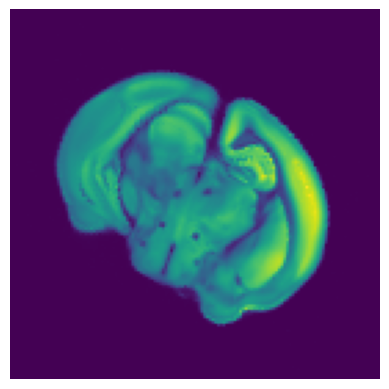

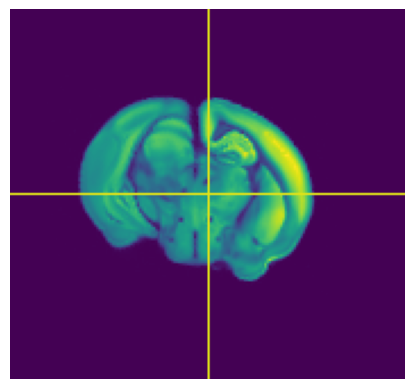

In [175]:
_plane = plane_mesh
_other_plane = [plane for plane in [display_plane, plane_mesh] if plane != _plane][0]
offset = 10
pitch = 20
yaw = 30
simulate(offset, pitch, yaw)
extract_significant_points(_plane)

# show(
#     [
#         _plane,
#         _other_plane,
#         vedo.Points(extract_significant_points(_plane), r=10, c="red"),
#         vedo.Points(extract_significant_points(_other_plane), r=10, c="red"),
#     ]
# )

image_plane_points = extract_significant_points(plane_mesh)
target_plane_points = extract_significant_points(display_plane)

# a = target_plane_points[0]
# c = target_plane_points[1]
a, c = extract_corners(target_plane_points)
b = (
    display_plane.points[0]
    if np.all(display_plane.points[1] == a)
    else display_plane.points[1]
)
d = (
    display_plane.points[2]
    if np.all(display_plane.points[3] == c)
    else display_plane.points[3]
)

A = image_plane_points[0]
C = image_plane_points[1]

e = euclidean(A, a)
e_prime = euclidean(C, c)

theta = vector_angle(b - a, a - A) % 90
if np.isnan(theta):
    theta = 0
theta_prime = -vector_angle(d - c, c - C) % 90
if np.isnan(theta_prime):
    theta_prime = 0

try:
    _x = round(e * math.cos(math.radians(theta)))
except ValueError:
    _x = 0
try:
    _y = round(e * math.sin(math.radians(theta)))
except ValueError:
    _y = 0

try:
    _x_prime = round(e_prime * math.cos(math.radians(theta_prime)))
except ValueError:
    _x_prime = 0
try:
    _y_prime = round(e_prime * math.sin(math.radians(theta_prime)))
except ValueError:
    _y_prime = 0

image = (
    plane_mesh.pointdata["ImageScalars"].reshape(plane_mesh.metadata["shape"]).copy()
)

if _x < 0:
    x = 0
else:
    x = _x - _x_prime if _x_prime < 0 else 0

if _y < 0:
    y = 0
else:
    y = _y - _y_prime if _y_prime < 0 else 0

if _x_prime < 0:
    x_prime = 0
else:
    x_prime = _x_prime - _x if _x < 0 else 0

if _y_prime < 0:
    y_prime = 0
else:
    y_prime = _y_prime - _y if _y < 0 else 0

# x = max(x, 0)
# y = max(y, 0)
# x_prime = max(x_prime, 0)
# y_prime = max(y_prime, 0)
# value1 = max(0, max(x, x_prime))
# value2 = max(0, max(y, y_prime))

# image = rotate(image, pitch, reshape=False)

# image = image[26:-3, 15:-22]
# image = image[x : image.shape[0] - x_prime, y : image.shape[1] - y_prime]
image = image[x_prime : image.shape[0] - x, y_prime : image.shape[1] - y]
# image = image[y : image.shape[0] - y_prime, x : image.shape[1] - x_prime]
# image = image[value2 : image.shape[0] - value2, value1 : image.shape[1] - value1]
# image = image[15 : -6]
# image = image[y : image.shape[1] - y_prime, x : image.shape[0] - x_prime]
# image = image[max1 : image.shape[0] - max1, max2 : image.shape[1] - max2]
# image[x, :] = 255
# image[:, y] = 255
# image[x_prime, :] = 255
# image[:, y_prime] = 255

image = rotate(image, pitch, reshape=False)

image[image.shape[0] // 2] = 255
image[..., image.shape[1] // 2] = 255

print(f"{theta=}")
print(f"{theta_prime=}")

print(f"{_x=}")
print(f"{_y=}")
print(f"{_x_prime=}")
print(f"{_y_prime=}")

print(f"{x=}")
print(f"{y=}")
print(f"{x_prime=}")
print(f"{y_prime=}")

print("Reference shape:", reference_image.shape)
print("Actual shape:", image.shape)

imshow(reference_image)
imshow(image)

In [174]:
show(
    [
        vedo.Point(a, c="red", r=10),
        vedo.Point(c, c="white", r=10),
        # vedo.Arrow(a, b, c="red", s=0.1),
        # vedo.Arrow(d, c, c="blue", s=0.1),
        # vedo.Arrow(a, A, c="orange", s=0.1),
        # vedo.Arrow(c, C, c="cyan", s=0.1),
        plane_mesh,
        display_plane,
    ]
)

In [169]:
a

array([135.4968  ,  13.316804, 139.24968 ], dtype=float32)

In [172]:
b

array([ 86.8168  , -58.9968  ,  17.180033], dtype=float32)

In [170]:
c

array([ 14.503196,  64.6832  , -27.249685], dtype=float32)

In [173]:
d

array([ 63.183197, 136.9968  ,  94.81997 ], dtype=float32)

In [171]:
display_plane.points

array([[135.4968  ,  13.316804, 139.24968 ],
       [ 86.8168  , -58.9968  ,  17.180033],
       [ 63.183197, 136.9968  ,  94.81997 ],
       [ 14.503196,  64.6832  , -27.249685]], dtype=float32)